In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.colors as mcolors

import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch

plt.rcParams['svg.fonttype'] = 'none'

data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/dev/benchmarks/fig_1_lymph_node_cell2loc/'
methods = glob(data_path + 'svg_scores/*.csv')

sample_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/cell2loc_human_lymph_node/'
adata = sc.read_h5ad(sample_path + 'chr.h5ad')
adata.var_names_make_unique()

/home/demeter_turos/anaconda3/envs/BearCovid/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


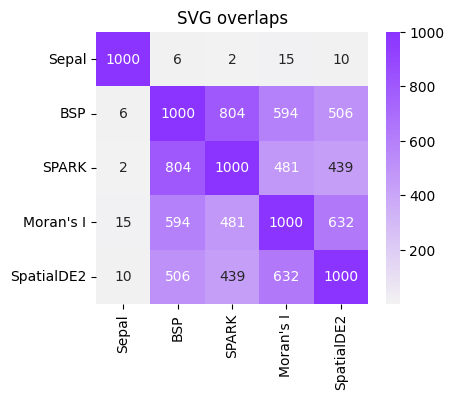

In [2]:
def color_to_color(first, last):
    # define the colors in the colormap
    colors = [first, last]
    # create a colormap object using the defined colors
    cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
    return cmap


# Moran's
top_1000 = {}
m_df = pd.DataFrame(adata.var["Moran's I"].copy())
m_df = m_df.sort_values(by="Moran's I", ascending=False)
m_df['spatially_variable'] = [1 if x < 1000 else 0 for x in range(len(m_df))]
top_1000["Moran's I"] = set(m_df.index[:1000])
svg_df = pd.DataFrame(data=m_df["spatially_variable"].values, columns=["Moran's I"],
                      index=m_df.index)

# BSP
bsp_path = methods[0]
m_df = pd.read_csv(bsp_path, index_col=0)
m_df = m_df.sort_values(by='p_values', ascending=True)
m_df['spatially_variable'] = [1 if x < 1000 else 0 for x in range(len(m_df))]
svg_df['BSP'] = m_df['spatially_variable']
top_1000['BSP'] = set(m_df.index[:1000])

# Sepal
sepal_path = methods[1]
m_df = pd.read_csv(sepal_path, index_col=0)
m_df = m_df.sort_values(by='sepal_score', ascending=False)
m_df['spatially_variable'] = [1 if x < 1000 else 0 for x in range(len(m_df))]
svg_df['Sepal'] = m_df['spatially_variable']
top_1000['Sepal'] = set(m_df.index[:1000])

# SPARK
spark_path = methods[2]
m_df = pd.read_csv(spark_path, index_col=0)
m_df = m_df.sort_values(by='adjustedPval', ascending=True)
m_df['spatially_variable'] = [1 if x < 1000 else 0 for x in range(len(m_df))]
svg_df['SPARK'] = m_df['spatially_variable']
top_1000['SPARK'] = set(m_df.index[:1000])

# SpatialDE2
spatialde_path = methods[3]
m_df = pd.read_csv(spatialde_path, index_col=0)
m_df = m_df.sort_values(by='padj', ascending=True)
m_df.index = m_df['gene']
m_df['spatially_variable'] = [1 if x < 1000 else 0 for x in range(len(m_df))]
svg_df['SpatialDE2'] = m_df['spatially_variable']
top_1000['SpatialDE2'] = set(m_df.index[:1000])

pairwise_overlaps = {}
for key1, set1 in top_1000.items():
    for key2, set2 in top_1000.items():
        # skip if comparing the set with itself or if the pair has already been checked
        if key1 == key2 or (key2, key1) in pairwise_overlaps:
            continue
        # calculate the overlap between the two sets
        overlap = set1.intersection(set2)
        # store the overlap in the pairwise overlaps dictionary
        pairwise_overlaps[(key1, key2)] = overlap

keys = set()
for key1, key2 in pairwise_overlaps.keys():
    keys.add(key1)
    keys.add(key2)
keys = list(keys)

overlap_matrix = np.zeros((len(keys), len(keys)), dtype=int)
# fill the overlap matrix
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if (key1, key2) in pairwise_overlaps:
            overlap_matrix[i, j] = len(pairwise_overlaps[(key1, key2)])
        elif (key2, key1) in pairwise_overlaps:
            overlap_matrix[i, j] = len(pairwise_overlaps[(key2, key1)])
        else:
            overlap_matrix[i, j] = 1000

overlap_df = pd.DataFrame(overlap_matrix, index=keys, columns=keys)

Z = linkage(overlap_df.T, method='ward')
order = leaves_list(Z)
overlap_df = overlap_df.iloc[:, order]

Z = linkage(overlap_df, method='ward')
order = leaves_list(Z)
overlap_df = overlap_df.iloc[order, :]

fig, ax = plt.subplots(1, 1, figsize=(6*0.8, 5*0.8))
sns.heatmap(overlap_df, ax=ax, cmap=color_to_color('#f2f2f2', '#8b33ff'),
            square=True, annot=True, fmt=".0f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title('SVG overlaps')
plt.tight_layout()
plt.show()

In [ ]:
adatas = {}
for c in tqdm(svg_df.columns):
    adata = sc.read_h5ad(sample_path + 'chr.h5ad')
    adata.var_names_make_unique()
    svg_df[c] = [True if x == 1 else False for x in svg_df[c]]
    adata.var['spatially_variable'] = svg_df[c]
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    ch.pca(adata, n_pcs=50)
    ch.aa(adata, n_pcs=20, n_archetypes=8)
    adatas[c] = adata

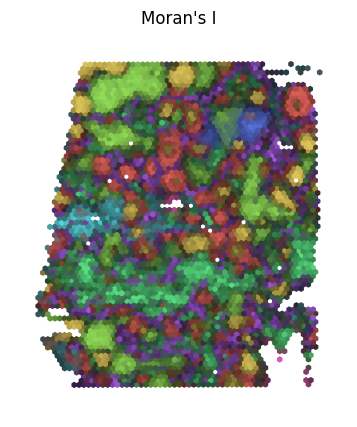

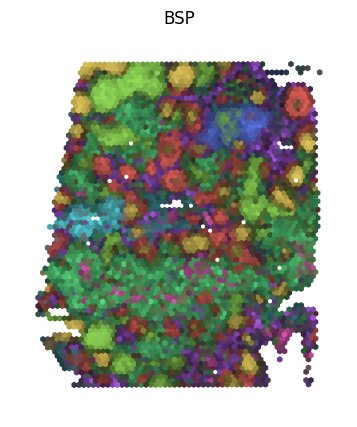

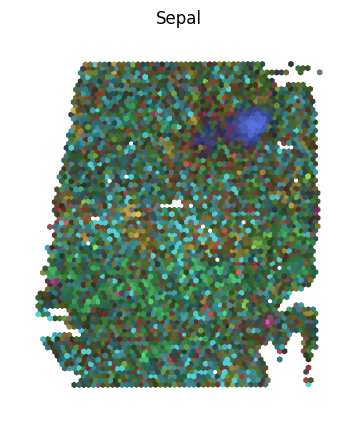

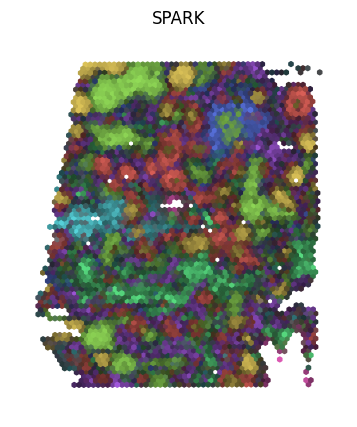

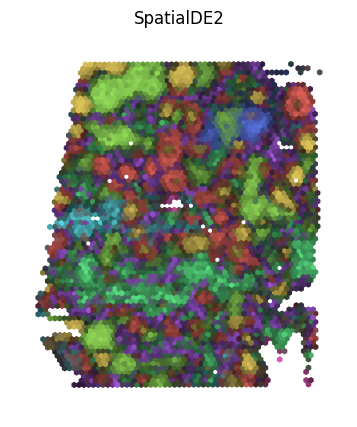

In [5]:
# chrysalis plots with the calculated SVGs
hexcodes = ['#91db57', '#57db80', '#5770db', '#dbc257', '#a157db', '#57d3db', '#db5f57', '#db57b2']


mcomps = adatas["Moran's I"].uns['chr_aa']['alphas']
mcomps_df = pd.DataFrame(mcomps)

for name, ad in adatas.items():
    if name == "Moran's I":
        continue
    else:
        comps = ad.uns['chr_aa']['alphas']
        comps_df = pd.DataFrame(comps)
        corr_matrix = np.empty((len(mcomps_df.columns), len(comps_df.columns)))
        for i, col1 in enumerate(mcomps_df.columns):
            for j, col2 in enumerate(comps_df.columns):
                corr, _ = pearsonr(mcomps_df[col1], comps_df[col2])
                corr_matrix[i, j] = corr
        # print(np.argmax(corr_matrix, axis=0))

hexdict = {
    "Moran's I": hexcodes,
    "BSP": [hexcodes[x] for x in [2, 4, 6, 5, 0, 7, 3, 1]],
    "Sepal": [hexcodes[x] for x in [0, 6, 5, 2, 1, 3, 0, 7]],
    "SPARK": [hexcodes[x] for x in [6, 0, 1, 3, 5, 4, 7, 2]],
    "SpatialDE2": [hexcodes[x] for x in [6, 1, 5, 4, 2, 0, 3, 7]],
}

for name, ad in adatas.items():
    ch.plot(ad, dim=8, hexcodes=hexdict[name], rasterized=True)
    plt.title(name)
    plt.show()

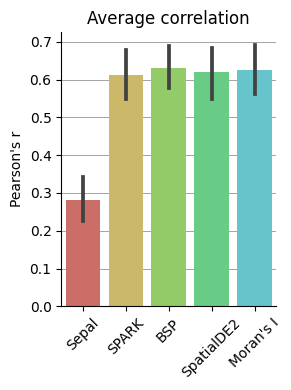

In [6]:
# method correlations

ref_data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/cell2loc_human_lymph_node/'

ref_adata = sc.read_h5ad(ref_data_path + 'sp.h5ad')
ref_adata.obs[ref_adata.uns['mod']['factor_names']] = ref_adata.obsm['q05_cell_abundance_w_sf']
cell_types = ref_adata.obs[ref_adata.uns['mod']['factor_names']].columns
adata.obs[cell_types] = ref_adata.obs[ref_adata.uns['mod']['factor_names']]
cell_type_df = adata.obs[cell_types]

method_corr = pd.DataFrame(index=cell_types)
for name, ad in adatas.items():
    compartment_df = pd.DataFrame(data=ad.obsm['chr_aa'],
                                  index=ad.obs_names,
                                  columns=range(ad.obsm['chr_aa'].shape[1]))

    corr_matrix = np.empty((len(cell_type_df.columns), len(compartment_df.columns)))
    for i, col1 in enumerate(cell_type_df.columns):
        for j, col2 in enumerate(compartment_df.columns):
            corr, _ = pearsonr(cell_type_df[col1], compartment_df[col2])
            corr_matrix[i, j] = corr

    corr_df = pd.DataFrame(data=corr_matrix, index=cell_type_df.columns, columns=compartment_df.columns)
    method_corr[name] = corr_df.max(axis=1)

method_corr = method_corr[["Sepal", "SPARK", "BSP", "SpatialDE2", "Moran's I"]]
hexcodes = ['#db5f57', '#dbc257', '#91db57', '#57db80', '#57d3db', '#5770db', '#a157db', '#db57b2']

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
sns.barplot(method_corr, palette=hexcodes)
ax.set_title('Average correlation')
ax.set_ylabel("Pearson's r")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [8]:
# geary's c
from scipy.stats import gaussian_kde

adata = sc.datasets.visium_sge(sample_id='V1_Human_Lymph_Node')

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_counts=6000)
sc.pp.filter_genes(adata, min_cells=10)
adata.var_names_make_unique()

ch.detect_svgs(adata, min_morans=0.05, min_spots=0.05, geary=True)

df = pd.DataFrame([adata.var["Geary's C"], adata.var["Moran's I"]]).T
df = df.dropna()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
x = df["Geary's C"]
y = df["Moran's I"]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
nx, ny, z = x[idx], np.array(y)[idx], z[idx]
x_list = nx.tolist()
y_list = ny.tolist()
r = np.corrcoef(x, y)[0, 1]

plt.scatter(x_list, y_list, alpha=1, c=z, s=1, cmap='rocket', rasterized=True)
ax.grid(axis='both')
ax.set_axisbelow(True)
ax.set_title(f"Pearson's r: {r:.3f} Genes: {int(len(df))}")
ax.set_aspect('auto')
ax.set_xlabel("Geary's C")
ax.set_ylabel("Moran's I")
row_range = np.ptp(df["Geary's C"])
col_range = np.ptp(df["Moran's I"])
ax.set_xlim((np.min(df["Geary's C"]) - 0.1 * row_range, np.max(df["Geary's C"]) + 0.1 * row_range))
ax.set_ylim((np.min(df["Moran's I"]) - 0.1 * col_range, np.max(df["Moran's I"]) + 0.1 * col_range))
plt.tight_layout()
plt.show()

Calculating SVGs:   7%|████                                                         | 897/13371 [00:31<07:17, 28.50it/s]


KeyboardInterrupt: 